# Notebook explaining how to implement an accelerating sinkhole into dataset
@author: Max Felius
@date: 07/05/2021
@version: 1.0.1
<br>
Implementing a sinkhole subsiding linearly
<br>

## Steps
- Loading and ordering of the data
- Define implented sinkhole parameters and preview data
    - Radius of influence
    - Event window
    - Maximum Subsidence
- Implenent defined sinkhole into the dataset
- Preview of the new displacement time series
- Save the new dataset

In [1]:
#imports
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os, sys, time
import re, datetime
from scipy import spatial
from decouple import config

#import personal functions
sys.path.extend(os.path.join(os.getcwd(),'sinkhole_functions'))
from sinkhole_functions.functions import *
from sinkhole_functions.geometric_models import *

## Loading and ordering
**Note**: Make sure the columns of the dataset are called *pnt_lon* and *pnt_lat*. Same for the location data columns.

In [2]:
folder = ''
filename = 't88_points_Franciscanerstraat_r100.csv'
location_file = 'sinkhole_kerkrade.csv'

#load the data
data = pd.read_csv(os.path.join(folder,filename))
location = pd.read_csv(os.path.join(folder,location_file))

#get information from pandas df
headers = list(data)
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.pnt_lon, data.pnt_lat))
data_gdf.crs = 'epsg:4326' #wgs84
location_gdf = gpd.GeoDataFrame(location, geometry=gpd.points_from_xy(location.longitude, location.latitude))
location_gdf.crs = 'epsg:4326' #wgs84

## Define sinkhole parameters and preview the data

The subsidence velocity implemented is -0.00084 millimeters per day^2.
The total amount of days of subsidence is 244 days.
The start date is 2018-06-01 00:00:00. The stop date is 2019-01-31 00:00:00.


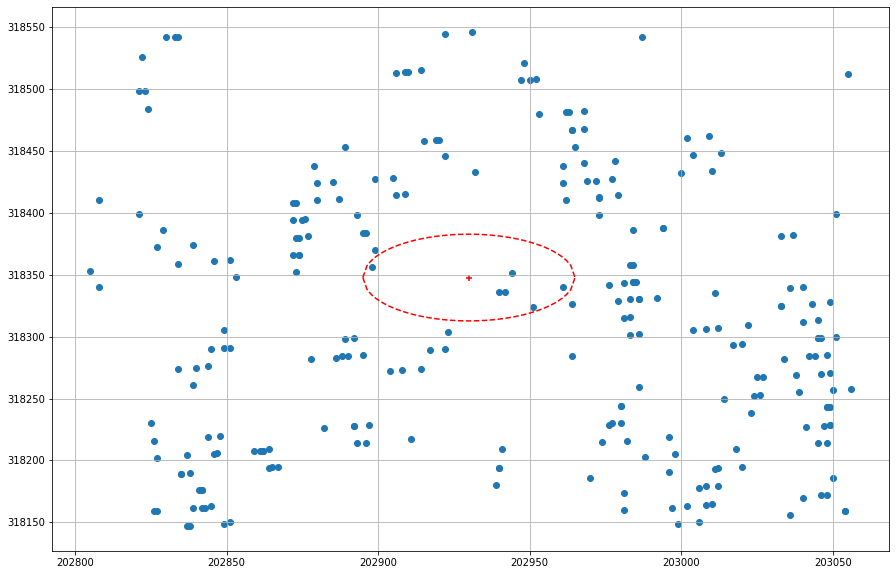

In [3]:
#The Sinkhole is active the last 10 epochs
epochs = np.array(get_sentinel_days(headers))

#-----------------------parameter selection----------------------------------------#
R = 35 #radius of influence of the sinkhole
total_center_subsidence = -0.05 #[m]
geometric_model_selected = 'gaussian'

#select event window
start_day_select = datetime.datetime(year=2018,month=6,day=1)
stop_day_select = datetime.datetime(year=2019,month=1,day=31)
#----------------------------------------------------------------------------------#

#compute some parameters
total_days = (stop_day_select - start_day_select).days
sub_velo = total_center_subsidence/(total_days**2) #m/day^2

print('The subsidence velocity implemented is {:.05f} millimeters per day^2.'.format(sub_velo*1000))
print('The total amount of days of subsidence is {} days.'.format(total_days))
print('The start date is {}. The stop date is {}.'.format(start_day_select,stop_day_select))

#convert location to Amersfoort Rijksdriehoekenstelsel
location_gdf = location_gdf.to_crs('epsg:28992')

#placing the sinkhole 
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(data['pnt_rdx'].values,data['pnt_rdy'].values)
ax.ticklabel_format(useOffset=False)
x0 = location_gdf.geometry.x.values[0]
y0 = location_gdf.geometry.y.values[0] 

x_test = np.linspace(x0-R,x0+R,50)

ax.scatter(x0,y0,c='r',marker='+')
ax.plot(x_test,[y0+np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')
ax.plot(x_test,[y0-np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')

ax.grid(True);

## Implement defined sinkhole into the dataset

In [4]:
#active sinkhole data
sinkhole_epochs_sel = np.array([False for _ in range(len(epochs))])
max_sub = []

#convert data to Amersfoort Rijksdriehoekenstelsel
data_gdf = data_gdf.to_crs('epsg:28992')

#select point locations
rdx = data_gdf.geometry.x.values
rdy = data_gdf.geometry.y.values

#compute distance towards the sinkhole center
r = np.sqrt((rdx - x0)**2 + (rdy - y0)**2)
rdz = kinematic_model(R,r,geometric_model_selected)

#implement sinkhole into dataset
for i,epoch in enumerate(epochs):
    epoch_datetime = datetime.datetime.strptime(epoch,'d_%Y%m%d')
    
    #start the sinkhole implementation
    if epoch_datetime >= start_day_select: 
        if epoch_datetime >= stop_day_select:
            max_sub_temp = sub_velo*(total_days**2)
            rdz_in = rdz*sub_velo*(total_days**2)
        
        else:
            max_sub_temp = sub_velo*((epoch_datetime - start_day_select).days**2)
            rdz_in = rdz*sub_velo*((epoch_datetime - start_day_select).days**2)
            sinkhole_epochs_sel[i] = True
            
        data_gdf[epoch] = data_gdf[epoch] + rdz_in
    else:
        max_sub_temp = 0
    
    max_sub.append(max_sub_temp)

#array with the epochs selected for the event window
sinkhole_epochs = epochs[sinkhole_epochs_sel]
print('Done')

Done


## Preview of the new displacement time series

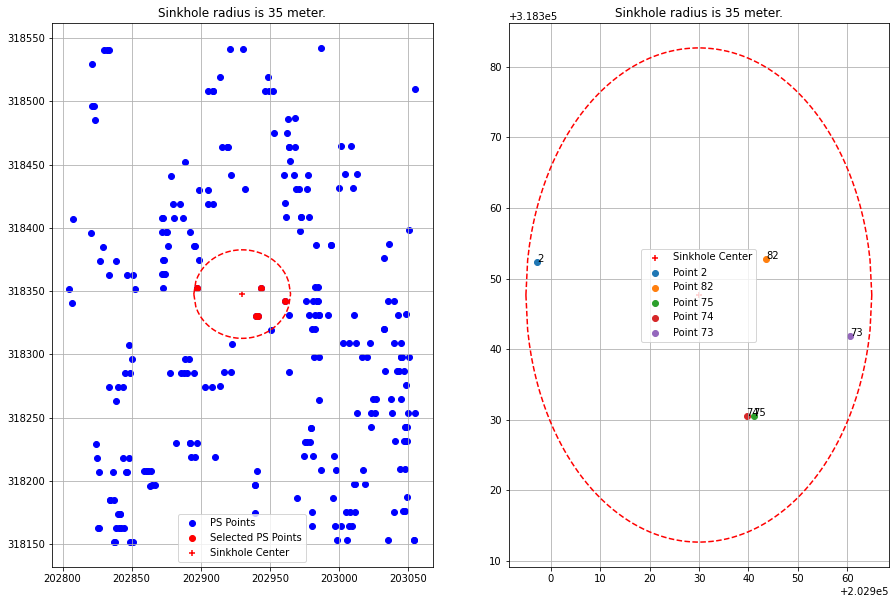

In [5]:
rd_data = np.concatenate((rdx.reshape(len(rdx),1),rdy.reshape(len(rdy),1)),axis=1)
tree = spatial.cKDTree(rd_data)
subset = tree.query_ball_point(([x0,y0]),r=R)

#placing the sinkhole 
fig, ax = plt.subplots(figsize=(15,10),nrows=1,ncols=2)

ax[0].scatter(rdx,rdy,c='b',label='PS Points')
ax[0].scatter(rdx[subset],rdy[subset],c='r',label='Selected PS Points')

R = 35 #radius of influence of the sinkhole
x_test = np.linspace(x0-R,x0+R,50)

ax[0].scatter(x0,y0,c='r',marker='+',label='Sinkhole Center')
ax[0].plot(x_test,[y0+np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')
ax[0].plot(x_test,[y0-np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')

ax[0].set_title(f'Sinkhole radius is {R} meter.')
ax[0].legend()
ax[0].grid(True);

#--------------NEW SUBPLOT----------------------
x_test = np.linspace(x0-R,x0+R,200)

# ax[1].scatter(rdx[subset],rdy[subset],c='r',label='Selected PS Points')
ax[1].scatter(x0,y0,c='r',marker='+',label='Sinkhole Center')
ax[1].plot(x_test,[y0+np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')
ax[1].plot(x_test,[y0-np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')

for isubset in subset:
    ax[1].scatter(rdx[isubset],rdy[isubset],label=f'Point {isubset}')
    ax[1].text(rdx[isubset],rdy[isubset],s=f'{isubset}')

ax[1].set_title(f'Sinkhole radius is {R} meter.')
ax[1].legend()
ax[1].grid(True);

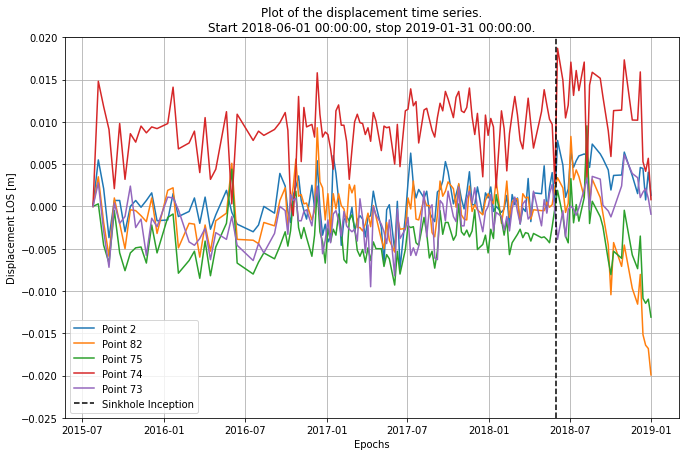

In [15]:
#time series of the selected points

plt.figure(figsize=(11,7))

for isubset in subset:
    plt.plot(get_sentinel_datetime(epochs),data_gdf[epochs].iloc[isubset],label=f'Point {isubset}')
#     plt.plot(get_sentinel_datetime(sinkhole_epochs),data_gdf[sinkhole_epochs].iloc[isubset],c='r')

plt.plot([start_day_select for _ in range(10)],np.linspace(-0.025,0.02,10),'k--',label='Sinkhole Inception')
plt.title(f'Plot of the displacement time series.\nStart {start_day_select}, stop {stop_day_select}.')
plt.ylabel('Displacement LOS [m]')
plt.xlabel('Epochs')
plt.ylim([-0.025,0.02])
plt.legend()
plt.grid(True);

plt.savefig('Accelerating_Subsidence_TS2.png')

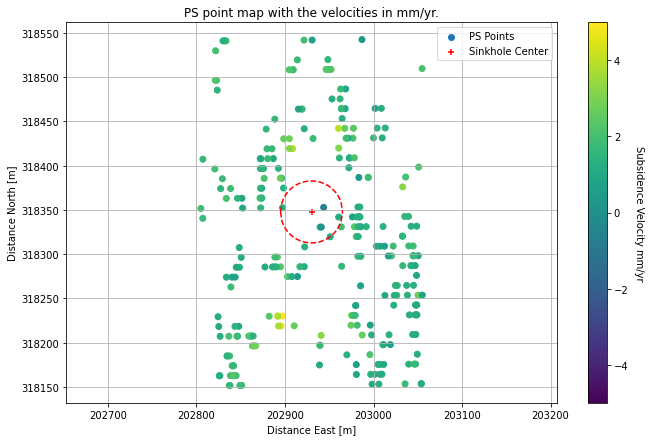

In [16]:
velo_save, b, sigma_ehat = linear_model(epochs,data_gdf)

velo_save = np.array(velo_save) * 365 * 1000

#placing the sinkhole 
fig, ax = plt.subplots(figsize=(11,7),nrows=1,ncols=1)

h = ax.scatter(rdx,rdy,c=velo_save,label='PS Points',vmin=-5,vmax=5)#,cmap='jet_r')
# ax[0].scatter(rdx[subset],rdy[subset],c='r',label='Selected PS Points')

cbar = plt.colorbar(h,ax=ax)
cbar.ax.get_yaxis().labelpad = 15
cbar.ax.set_ylabel('Subsidence Velocity mm/yr', rotation=270)

R = 35 #radius of influence of the sinkhole
x_test = np.linspace(x0-R,x0+R,50)

ax.scatter(x0,y0,c='r',marker='+',label='Sinkhole Center')
ax.plot(x_test,[y0+np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')
ax.plot(x_test,[y0-np.sqrt(R**2 - (rx-x0)**2) for rx in x_test],'r--')

ax.set_title(f'PS point map with the velocities in mm/yr.')
ax.legend()
ax.axis('equal')
ax.set_xlabel('Distance East [m]')
ax.set_ylabel('Distance North [m]')
ax.grid(True);

plt.savefig('Velocity_Map_Accelerating2.png')

## Save the new dataset

In [8]:
#save the new dataset 
# data_gdf.to_csv(os.path.join(folder,'Sinkhole_Implemented_Dataset_acc.csv'))

# Accelerating Maximum Subsidence 

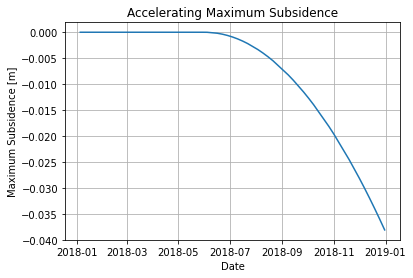

In [9]:
max_sub_signal = np.array(max_sub)

plt.figure()

i =100
plt.plot(get_sentinel_datetime(epochs)[i:],max_sub_signal[i:])

plt.title('Accelerating Maximum Subsidence')
plt.xlabel('Date')
plt.ylabel('Maximum Subsidence [m]')

plt.grid(True);

In [10]:
#save the new dataset 
data_gdf.to_csv(os.path.join(folder,'Implemented_accelerating_Franciscanerstraat_sinkhole_final.csv'))